In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [3]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [4]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

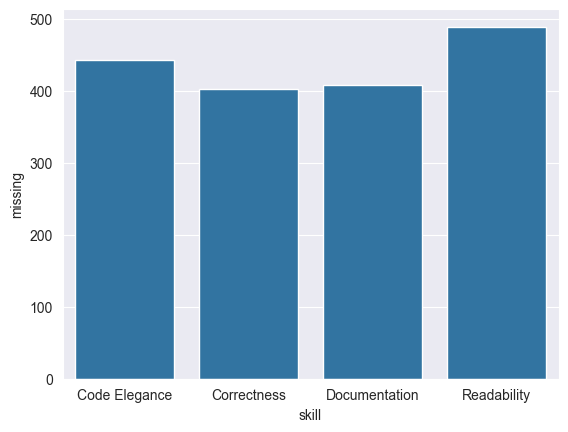

In [5]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [6]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [68]:
base_stopwords = nltk.corpus.stopwords.words('english')
base_stopwords += ['readability', 'correctness', 'documentation', 'maintainability', 'student']

### Sentiment

In [8]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [9]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


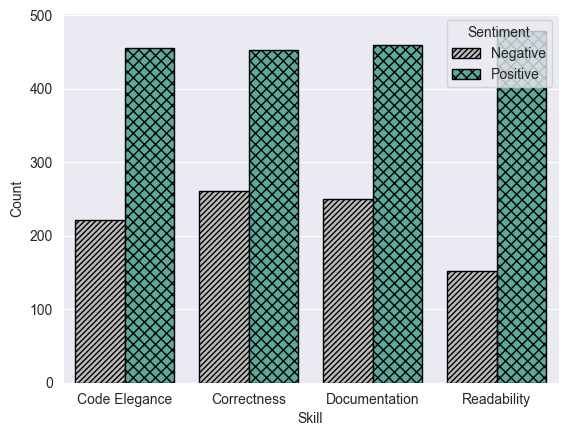

In [10]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [11]:
# TODO: Add plots for word counts of topic key words
# TODO: Add plots for dominant topic per document

In [41]:
def process_words(texts, bigram_mod, trigram_mod, stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        stemmer = SnowballStemmer('english')
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

In [54]:
def get_data(skill, addition_stopwords):
    
    stopwords = base_stopwords + addition_stopwords
    
    text_data = nlp_df[nlp_df['skill'] == skill]['comments']
    bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[text_data], threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_text = process_words(text_data, bigram_mod, trigram_mod, stopwords, stem=False, allowed_postags=['NOUN'])
    dictionary = corpora.Dictionary(processed_text)
    dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
    corpus = [dictionary.doc2bow(text) for text in processed_text]

    model = TfidfModel(corpus)
    tfidf_corpus = [model[i] for i in corpus]
    
    return tfidf_corpus, dictionary, processed_text
    

In [55]:
def generate_topic_model(corpus, dictionary, processed_text, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [56]:
def generate_topic_models(tfidf_corpus, dictionary, processed_text):
    models = {}
    coherence_results = []
    
    for topic_count in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]):
        model, coherence = generate_topic_model(tfidf_corpus, dictionary, processed_text, topic_count)
        models[topic_count] = model
        coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
        
    return models, pd.DataFrame(coherence_results)
    

In [57]:
def run_lda(skill, addition_stopwords=None):
    if addition_stopwords is None:
        addition_stopwords = []
    
    tfidf_corpus, dictionary, processed_text = get_data(skill, addition_stopwords)
    models, coherence_df= generate_topic_models(tfidf_corpus, dictionary, processed_text)
    print(coherence_df)

    g = sns.lineplot(coherence_df, x='topic_count', y='coherence')
    g.set(title=skill)
    return models, tfidf_corpus, processed_text

#### Plots

In [58]:
def run_pyLDAvis(models, topic_count):
    return pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)

In [67]:
def generate_word_cloud(models, topic_count, topic_names=None, additional_stopwords=None):
    if additional_stopwords is None:
        additional_stopwords = {}
        
    stopwords = base_stopwords + additional_stopwords
        
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None
        
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    topics = models[topic_count].show_topics(formatted=False, num_words=5)
    
    fig, axes = plt.subplots((int(topic_count) // 2) + int(topic_count) % 2, 2, figsize=(10,10), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i >= topic_count:
            break
        
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        if topic_names is None:
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        else:
            plt.gca().set_title('Topic: ' + topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [112]:
# Look for words in multiple topics and have higher frequency then weight. Add these to stop words
def generate_word_count(models, topic_count, data, topic_names=None):
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None


    topics = models[topic_count].show_topics(formatted=False)
    data_flat = [w for w_list in data for w in w_list]
    counter = Counter(data_flat)
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])
    
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(topic_count // 2 + topic_count % 2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        if i >= topic_count:
            break

        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        if topic_names is None:
            ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        else:
            ax.set_title('Topic: ' + topic_names[i], color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
    fig.tight_layout(w_pad=2)
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
    plt.show()
    

### Correctness

100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

    topic_count  coherence
0             1 -12.927959
1             2 -12.762698
2             3 -12.758392
3             4 -12.785848
4             5 -12.803318
5             6 -12.802257
6             7 -12.819111
7             8 -12.797263
8             9 -12.798419
9            10 -12.796128
10           20 -12.725952
11           30 -12.872544
12           40 -12.870976
13           50 -12.871296
14          100 -12.871891


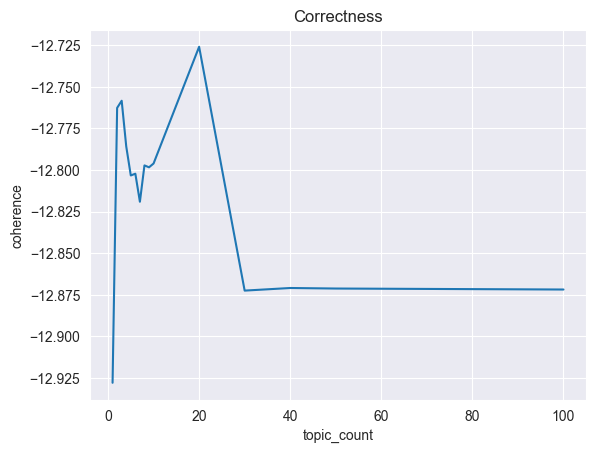

In [104]:
additional_stopwords = ['application', 'base', 'addition', 'animal', 'effect', 'implementation', 'source', 'issue', 'approach', 'assignment', 'simulation', 'animal', 'weather', 'species', 'disease', 'plant', 'code', 'baseline', 'time', 'day', 'predator', 'requirement', 'track', 'level', 'resource', 'fight', 'feature', 'class', 'behavior', 'behaviour', 'standard', 'rabbit', 'gender', 'fox', 'night', 'prey', 'growth', 'meet', 'male', 'female', 'propagate', 'aptitude']
models, corpus, processed_text= run_lda('Correctness', additional_stopwords)

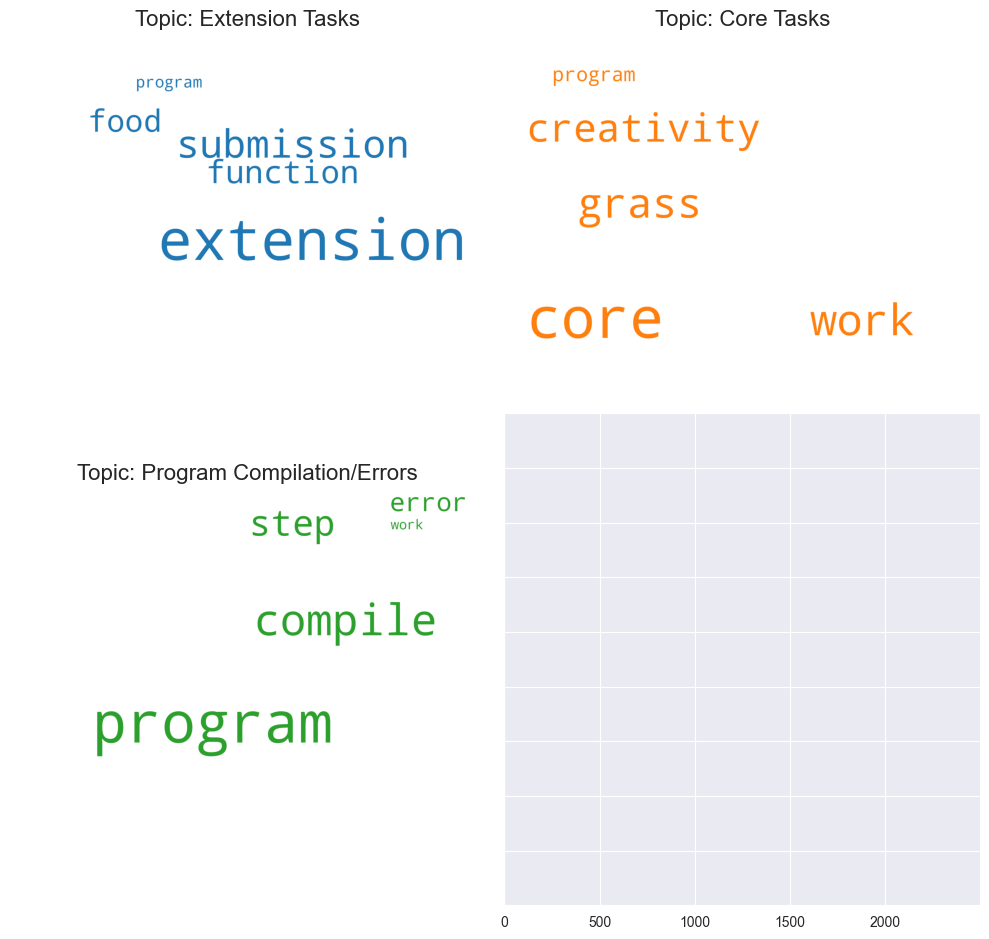

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/816966090.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/816966090.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/816966090.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


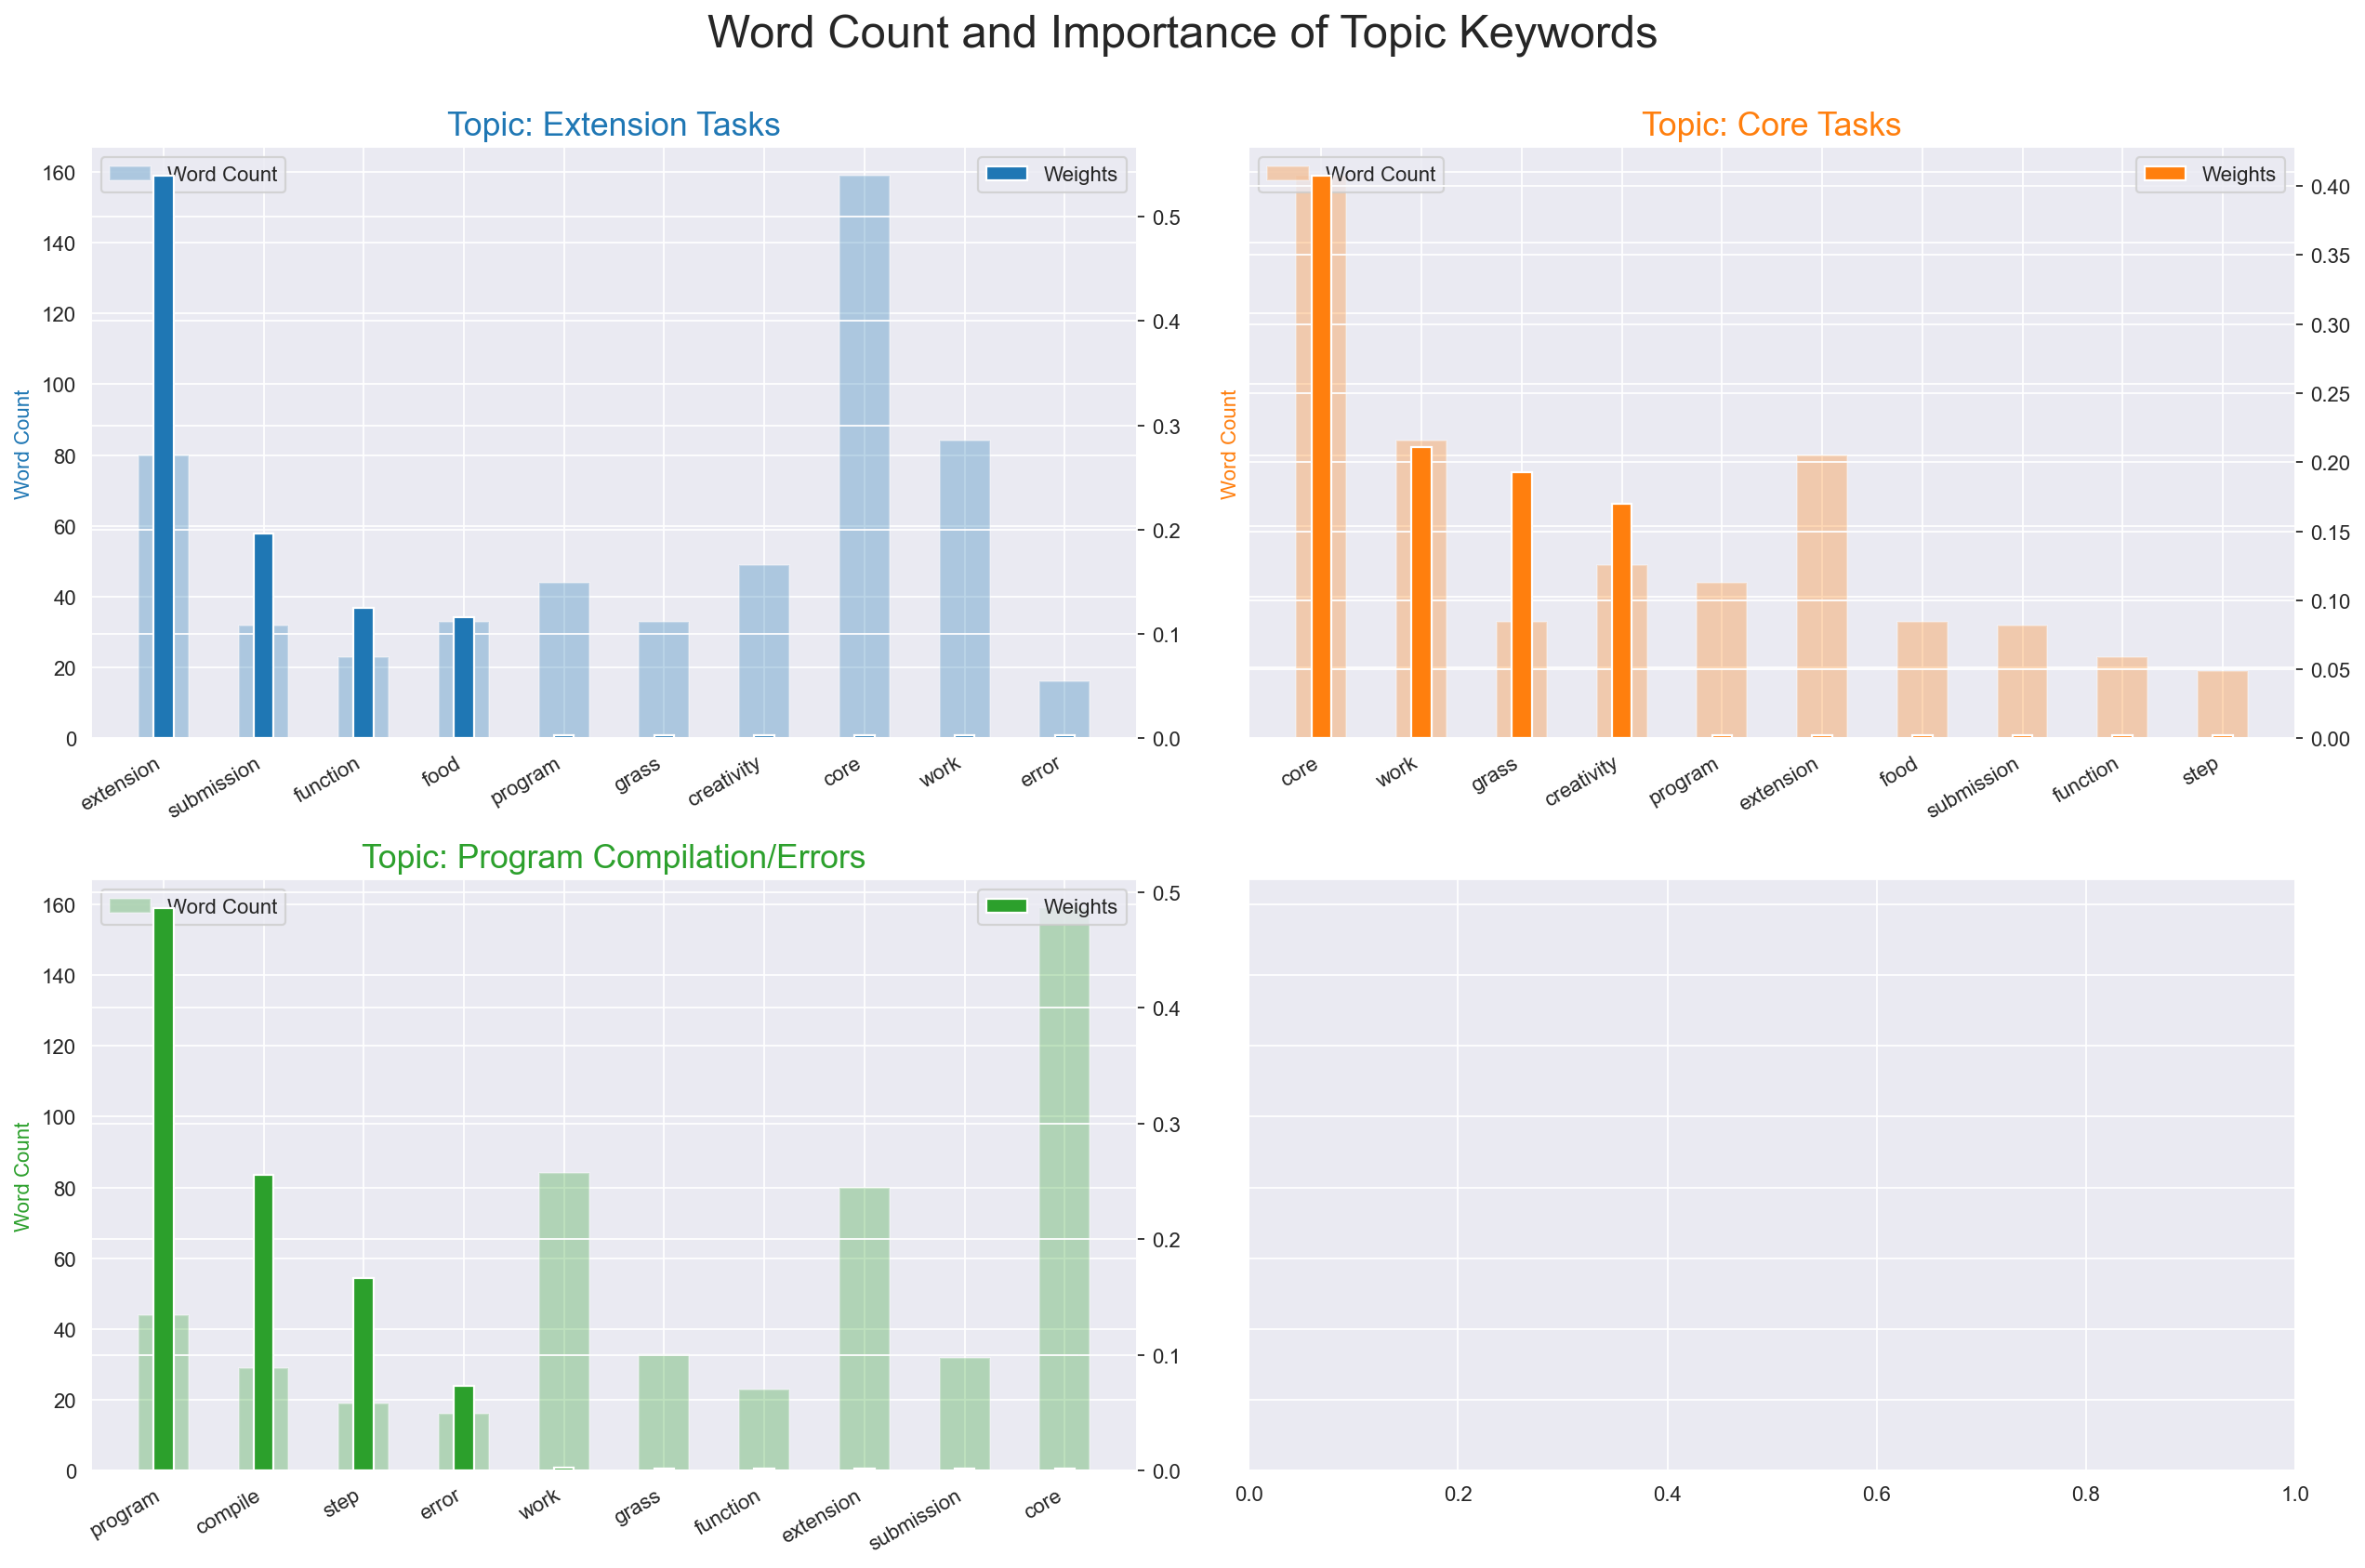

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.262964  0.252479       1        1  40.920987
0      0.089346 -0.351730       2        1  32.326630
2     -0.352310  0.099251       3        1  26.752384, topic_info=          Term       Freq      Total Category  logprob  loglift
4    extension  76.000000  76.000000  Default  12.0000  12.0000
10     program  57.000000  57.000000  Default  11.0000  11.0000
0         core  73.000000  73.000000  Default  10.0000  10.0000
8      compile  30.000000  30.000000  Default   9.0000   9.0000
2         work  38.000000  38.000000  Default   8.0000   8.0000
5   submission  28.000000  28.000000  Default   7.0000   7.0000
3        grass  35.000000  35.000000  Default   6.0000   6.0000
11        step  20.000000  20.000000  Default   5.0000   5.0000
9   creativity  31.000000  31.000000  Default   4.0000   4.0000
6     function  18.000000  18.000000  Default   3.0000   3.0000
1         food  17.000000  17.000000  Default   2.0000   2.0000
7        error   9.000000   9.000000  Default   1.0000   1.0000
0         core  72.759383  73.429231   Topic1  -0.8974   0.8844
2         work  37.620164  38.358370   Topic1  -1.5570   0.8741
3        grass  34.358335  35.045535   Topic1  -1.6477   0.8737
9   creativity  30.343150  31.011961   Topic1  -1.7720   0.8717
7        error   0.417877   9.343326   Topic1  -6.0571  -2.2137
1         food   0.423736  17.027109   Topic1  -6.0432  -2.7999
6     function   0.419564  18.379583   Topic1  -6.0531  -2.8863
11        step   0.419311  20.230149   Topic1  -6.0537  -2.9828
5   submission   0.421560  28.313383   Topic1  -6.0483  -3.3136
8      compile   0.418338  30.639580   Topic1  -6.0560  -3.4002
10     program   0.466755  57.664451   Topic1  -5.9465  -3.9231
4    extension   0.424620  76.746197   Topic1  -6.0411  -4.3035
4    extension  76.060888  76.746197   Topic2  -0.6173   1.1203
5   submission  27.634225  28.313383   Topic2  -1.6297   1.1050
6     function  17.690360  18.379583   Topic2  -2.0758   1.0911
1         food  16.348609  17.027109   Topic2  -2.1547   1.0886
7        error   0.401109   9.343326   Topic2  -5.8623  -2.0189
11        step   0.400274  20.230149   Topic2  -5.8644  -2.7935
9   creativity   0.412496  31.011961   Topic2  -5.8343  -3.1906
8      compile   0.399378  30.639580   Topic2  -5.8666  -3.2109
3        grass   0.416758  35.045535   Topic2  -5.8240  -3.3026
2         work   0.411767  38.358370   Topic2  -5.8361  -3.4050
10     program   0.416901  57.664451   Topic2  -5.8237  -3.8003
0         core   0.412392  73.429231   Topic2  -5.8346  -4.0528
10     program  56.780795  57.664451   Topic3  -0.7203   1.3031
8      compile  29.821864  30.639580   Topic3  -1.3643   1.2915
11        step  19.410564  20.230149   Topic3  -1.7937   1.2772
7        error   8.524340   9.343326   Topic3  -2.6166   1.2268
1         food   0.254764  17.027109   Topic3  -6.1269  -2.8837
6     function   0.269658  18.379583   Topic3  -6.0701  -2.9033
5   submission   0.257598  28.313383   Topic3  -6.1159  -3.3811
2         work   0.326439  38.358370   Topic3  -5.8790  -3.4479
9   creativity   0.256315  31.011961   Topic3  -6.1209  -3.4772
3        grass   0.270443  35.045535   Topic3  -6.0672  -3.5458
0         core   0.257456  73.429231   Topic3  -6.1164  -4.3347
4    extension   0.260689  76.746197   Topic3  -6.1040  -4.3664, token_table=      Topic      Freq        Term
term                             
8         3  0.979126     compile
0         1  0.994154        core
9         1  0.967369  creativity
7         3  0.963254       error
4         2  0.990277   extension
1         2  0.939678        food
6         2  0.979348    function
3         1  0.970166       grass
10        3  0.988477     program
11        3  0.939192        step
5         2  0.988932  submission
2         1  0.990657        work, R=12, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC

In [113]:
TOPIC_COUNT = 3
topic_names = {0: 'Extension Tasks', 1: 'Core Tasks', 2: 'Program Compilation/Errors'}
generate_word_cloud(models, TOPIC_COUNT, topic_names)
generate_word_count(models, TOPIC_COUNT, processed_text, topic_names)
run_pyLDAvis(models, TOPIC_COUNT)

### Code Elegance

In [62]:
models, corpus, processed_text = run_lda('Code Elegance')

NameError: name 'base_stopwords' is not defined

In [ ]:
TOPIC_COUNT = 6
generate_word_cloud(models, TOPIC_COUNT)
generate_word_count(models, TOPIC_COUNT, processed_text)
run_pyLDAvis(models, TOPIC_COUNT)

### Readability

In [63]:
models, corpus, processed_text = run_lda('Readability')

NameError: name 'base_stopwords' is not defined

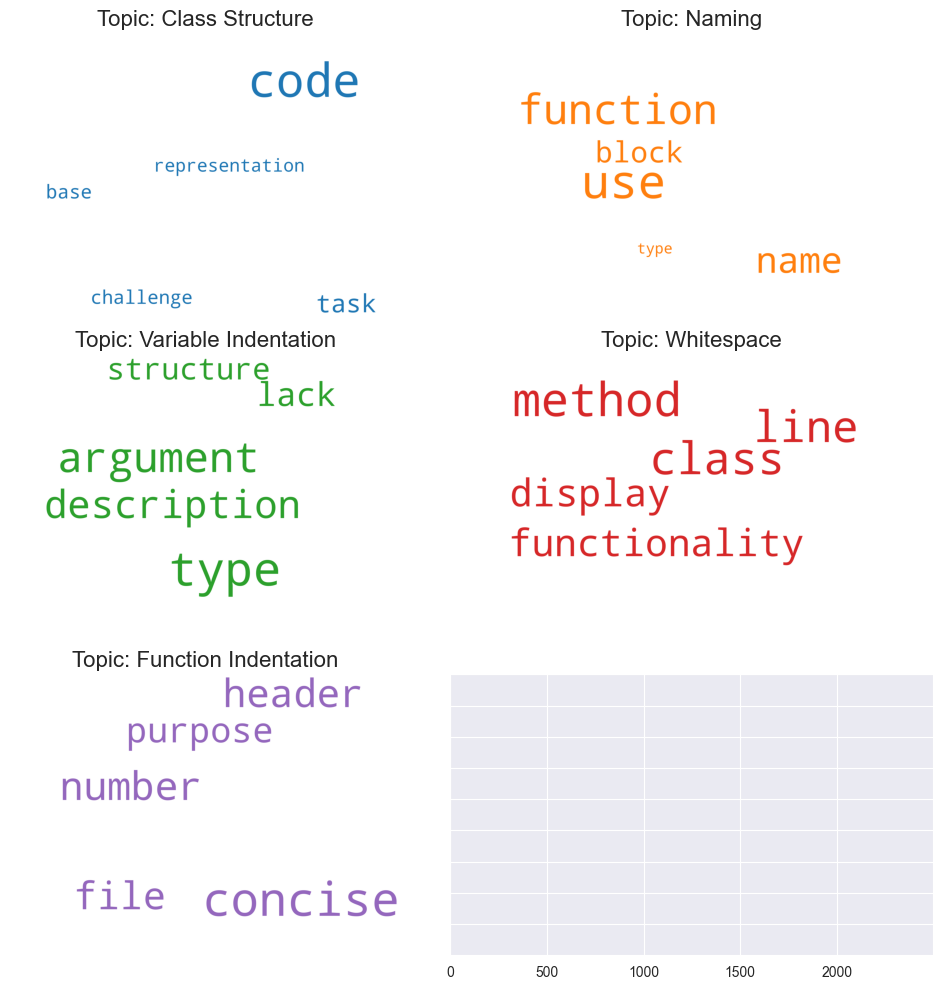

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/3243870486.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/3243870486.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/3243870486.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/3243870486.py:25: 

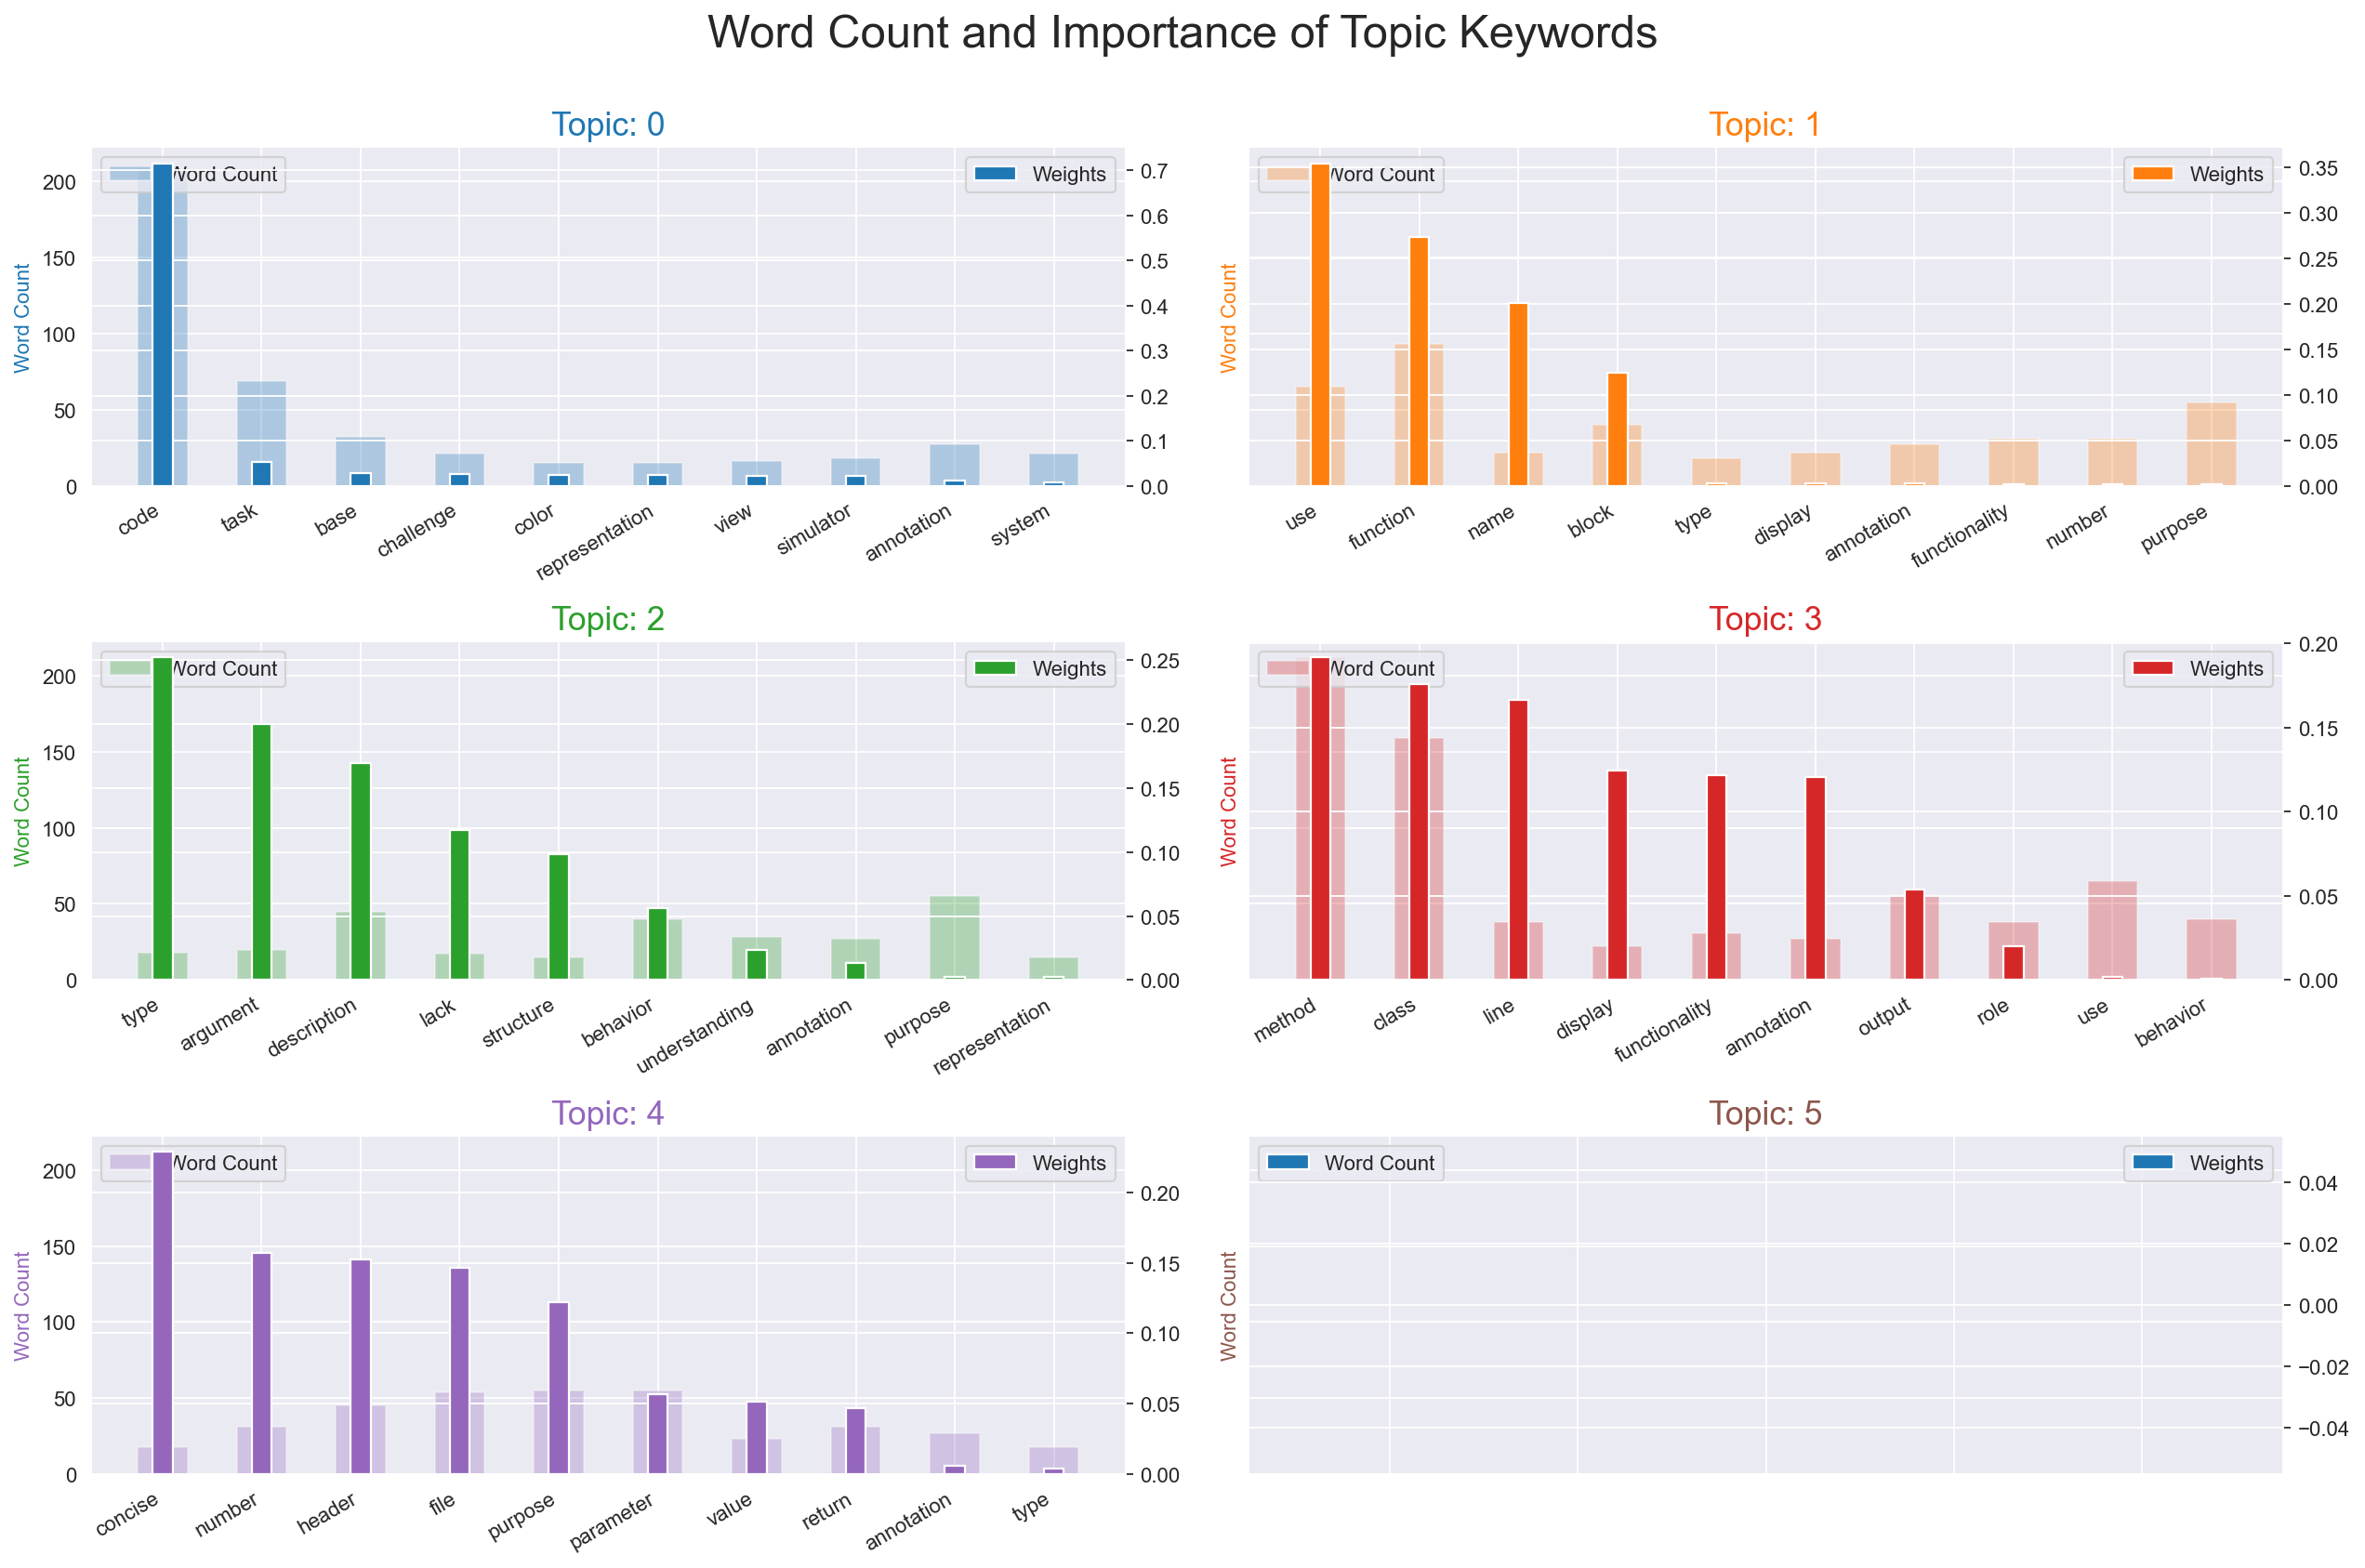

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.191997  0.277442       1        1  26.164488
4      0.071853 -0.336191       2        1  20.663803
0      0.065368  0.007082       3        1  20.152067
1     -0.387331  0.073134       4        1  16.847930
2      0.058114 -0.021468       5        1  16.171712, topic_info=        Term        Freq       Total Category  logprob  loglift
8       code  120.000000  120.000000  Default  30.0000  30.0000
18       use   50.000000   50.000000  Default  29.0000  29.0000
22  function   39.000000   39.000000  Default  28.0000  28.0000
24      type   35.000000   35.000000  Default  27.0000  27.0000
23   concise   40.000000   40.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
3       line    0.311984   37.043973   Topic5  -6.0600  -2.9550
4     method    0.311703   42.519591   Topic5  -6.0609  -3.0938
8       code    0.314900  120.027934   Topic5  -6.0507  -4.1213
18       use    0.310303   50.598505   Topic5  -6.0654  -3.2722
23   concise    0.310059   40.143501   Topic5  -6.0662  -3.0415

[214 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        1  0.833059      annotation
16        2  0.032041      annotation
16        3  0.064081      annotation
16        5  0.064081      annotation
25        5  0.973669        argument
28        3  0.919725            base
14        5  0.940622        behavior
7         4  0.923702           block
32        3  0.755126       challenge
0         1  0.972033           class
8         3  0.991436            code
35        3  0.825495           color
23        2  0.971515         concise
15        5  0.972551     description
27        1  0.961501         display
29        3  0.549492     elaboration
1         2  0.959039            file
22        4  0.970407        function
9         1  0.949872   functionality
2         2  0.958674          header
11        5  0.960178            lack
3         1  0.971818            line
4         1  0.964261          method
26        4  0.962522            name
30        2  0.969752          number
17        1  0.942238          output
5         2  0.931178       parameter
6         2  0.957887         purpose
36        3  0.825495  representation
20        2  0.885062          return
21        1  0.732875            role
33        3  0.874300       simulator
13        5  0.919975       structure
31        3  0.526742          system
19        3  0.951753            task
24        2  0.028308            type
24        5  0.962456            type
12        5  0.732647   understanding
18        4  0.968408             use
10        2  0.912333           value
34        3  0.868057            view, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

In [64]:
TOPIC_COUNT = 5
generate_word_cloud(models, TOPIC_COUNT, topic_names=['Class Structure', 'Naming', 'Variable Indentation', 'Whitespace', 'Function Indentation'])
generate_word_count(models, TOPIC_COUNT, processed_text)
run_pyLDAvis(models, TOPIC_COUNT)

### Documentation

In [65]:
models, corpus, processed_text = run_lda('Documentation')

NameError: name 'base_stopwords' is not defined

In [ ]:
TOPIC_COUNT = 6
generate_word_cloud(models, TOPIC_COUNT)
generate_word_count(models, TOPIC_COUNT, processed_text)
run_pyLDAvis(models, TOPIC_COUNT)